In [1]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import math
import random
import datetime as dt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error



Import Data

In [2]:
df = pd.read_csv('C:/Users/yolau/OneDrive/Documents/TA/Kodingan/BBCA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-18,4180.0,4220.0,4170.0,4220.0,3802.38208,76474000
1,2017-12-19,4190.0,4250.0,4190.0,4220.0,3802.38208,76553500
2,2017-12-20,4210.0,4210.0,4175.0,4185.0,3770.84668,102963500
3,2017-12-21,4190.0,4230.0,4190.0,4220.0,3802.38208,61100000
4,2017-12-22,4235.0,4335.0,4195.0,4300.0,3874.46582,94573000


In [3]:
specific_df = df[['Date', 'Close', 'Open', 'High', 'Low']]

In [4]:
specific_df

,Date,Close,Open,High,Low
0,2017-12-18,4220.0,4180.0,4220.0,4170.0
1,2017-12-19,4220.0,4190.0,4250.0,4190.0
2,2017-12-20,4185.0,4210.0,4210.0,4175.0
3,2017-12-21,4220.0,4190.0,4230.0,4190.0
4,2017-12-22,4300.0,4235.0,4335.0,4195.0
...,...,...,...,...,...
1489,2023-12-08,8750.0,8800.0,8850.0,8750.0
1490,2023-12-11,8750.0,8675.0,8775.0,8675.0
1491,2023-12-12,8700.0,8700.0,8750.0,8700.0
1492,2023-12-13,8675.0,8700.0,8750.0,8675.0


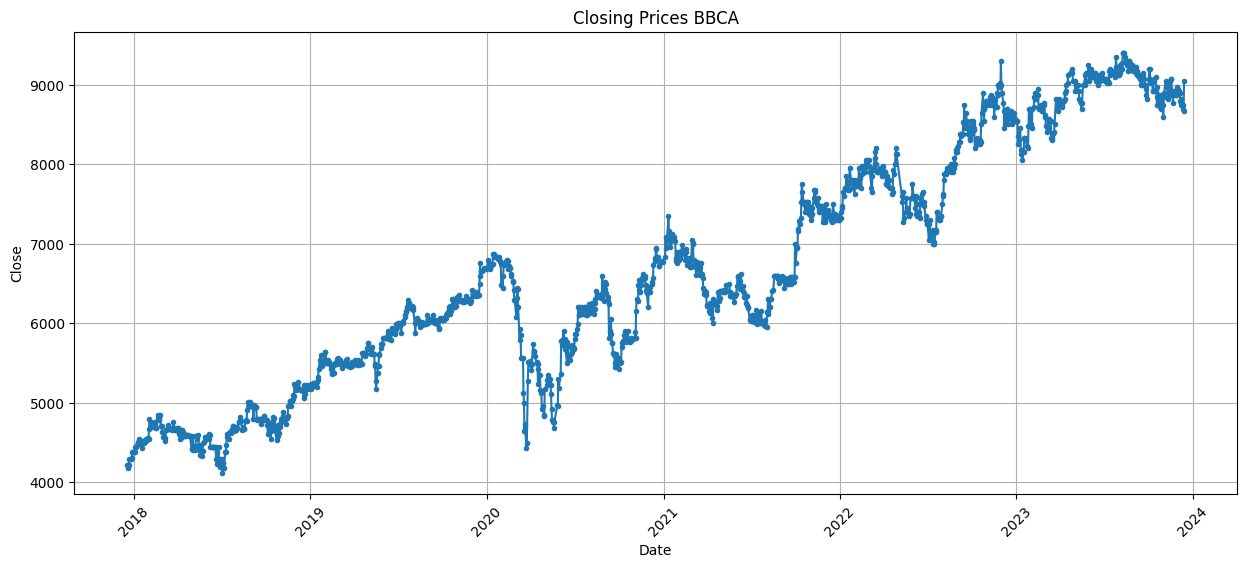

In [5]:
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], marker='.')
plt.title('Closing Prices BBCA')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

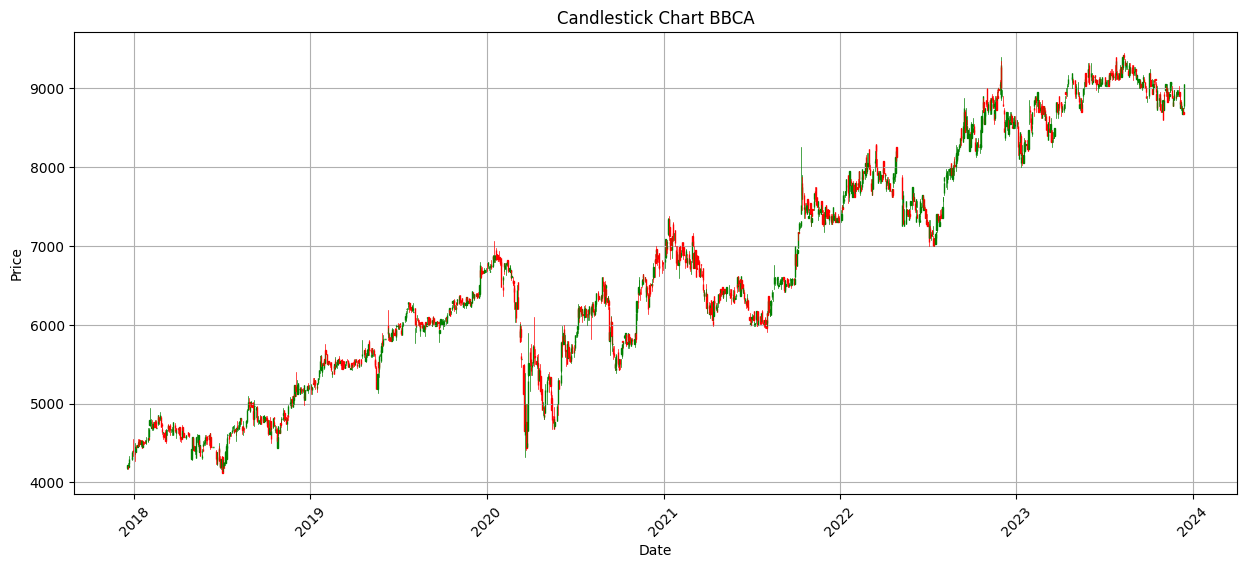

In [6]:
matplotlib_date = mdates.date2num(specific_df['Date'])

ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['High'], specific_df['Low'], specific_df['Close'])).T

plt.figure(figsize=(15,6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart BBCA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

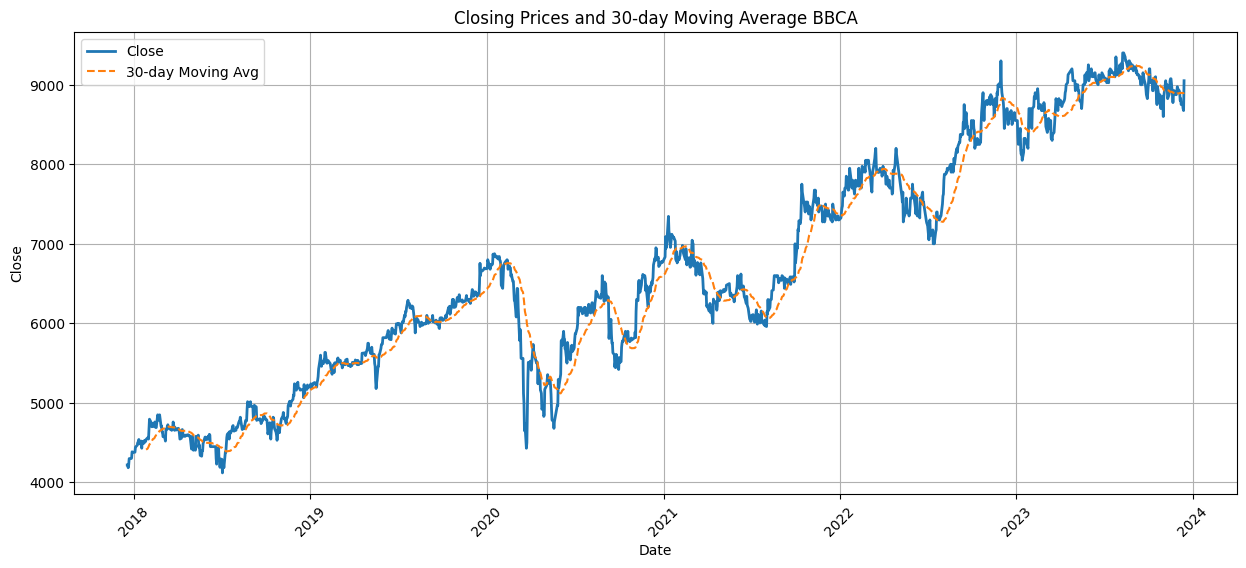

In [7]:
window = 30
plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], label='Close', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Close'].rolling(window=window).mean(),label=f'{window}-day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-day Moving Average BBCA')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [8]:
specific_df.head()

,Date,Close,Open,High,Low
0,2017-12-18,4220.0,4180.0,4220.0,4170.0
1,2017-12-19,4220.0,4190.0,4250.0,4190.0
2,2017-12-20,4185.0,4210.0,4210.0,4175.0
3,2017-12-21,4220.0,4190.0,4230.0,4190.0
4,2017-12-22,4300.0,4235.0,4335.0,4195.0


In [9]:
new_df = specific_df.reset_index()['Close']

In [10]:
new_df

0       4220.0
1       4220.0
2       4185.0
3       4220.0
4       4300.0
         ...  
1489    8750.0
1490    8750.0
1491    8700.0
1492    8675.0
1493    9050.0
Name: Close, Length: 1494, dtype: float64

In [11]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1,1))

Partisi Data

In [12]:
train_size = int(len(scaled_data)*0.9) #90% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [13]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [14]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1284, 60)
(1284,)


Testing set size:-
(90, 60)
(90,)


(None, None)

In [15]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [16]:
Layer = 3

In [17]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [19]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [20]:
checkpoints = ModelCheckpoint(filepath= 'bbca.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100

41/41 [==============================] - 13s 92ms/step - loss: 0.1065 - val_loss: 0.1162
Epoch 2/100
41/41 [==============================] - 2s 54ms/step - loss: 0.0589 - val_loss: 0.0227
Epoch 3/100
41/41 [==============================] - 2s 53ms/step - loss: 0.0451 - val_loss: 0.0359
Epoch 4/100
41/41 [==============================] - 2s 54ms/step - loss: 0.0419 - val_loss: 0.0363
Epoch 5/100
41/41 [==============================] - 2s 55ms/step - loss: 0.0358 - val_loss: 0.0814
Epoch 6/100
41/41 [==============================] - 2s 54ms/step - loss: 0.0342 - val_loss: 0.0340
Epoch 7/100
41/41 [==============================] - 2s 54ms/step - loss: 0.0306 - val_loss: 0.0902
Epoch 8/100
41/41 [==============================] - 2s 55ms/step - loss: 0.0303 - val_loss: 0.0147
Epoch 9/100
41/41 [==============================] - 2s 55ms/step - loss: 0.0248 - val_loss: 0.0230
Epoch 10/100
41/41 [==============================] - 2s 58ms/step - loss: 0.0249 - val_loss: 0.01

In [21]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

3/3 [==============================] - 0s 23ms/step


In [22]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [23]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.05704820096128193
0.042266918891668524


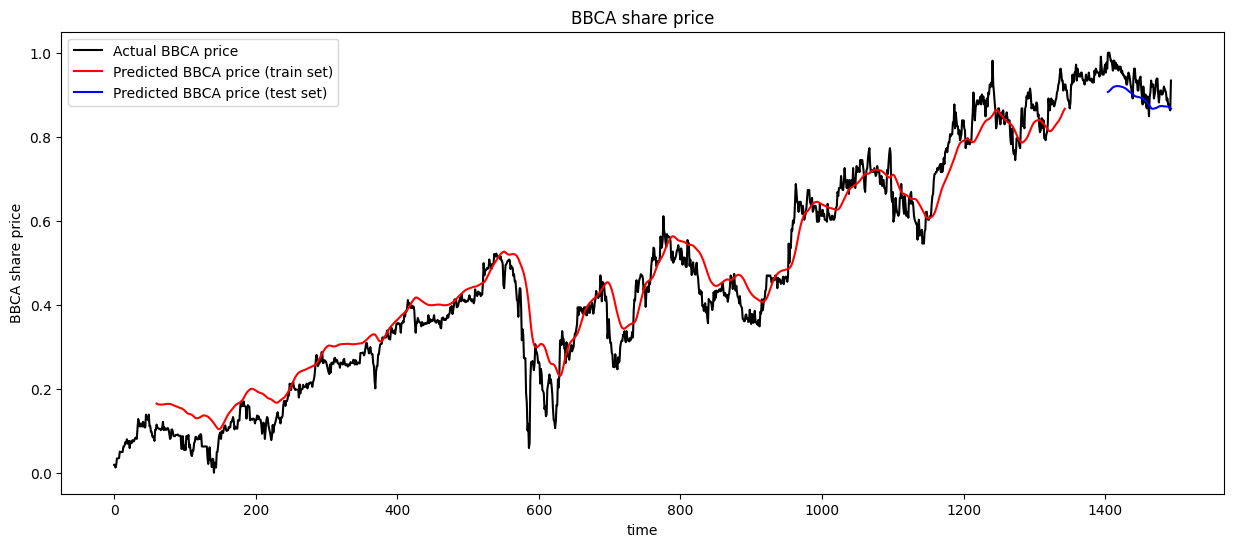

In [24]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual BBCA price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted BBCA price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted BBCA price (test set)")

plt.title(f"BBCA share price")
plt.xlabel("time")
plt.ylabel(f"BBCA share price")
plt.legend()
plt.show()

In [25]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 48ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 8698.1494140625
Day 2: Predicted Price = 8688.6796875
Day 3: Predicted Price = 8678.5244140625
Day 4: Predicted Price = 8668.0078125
Day 5: Predicted Price = 8657.3603515625
Day 6: Predicted Price = 8646.7275390625
Day 7: Predicted Price = 8636.2080078125
Day 8: Predicted Price = 8625.84765625
Day 9: Predicted Price = 8615.611328125
Day 10: Predicted Price = 8605.5390625
Day 11: Predicted Price = 8595.658203125
Day 12: Predicted Price = 8585.98828125
Day 13: Predicted Price = 8576.501953125
Day 14: Predicted Price = 8567.1748046875
Day 15: Predicted Price = 8558.0283203125
Day 16: Predicted Price = 8549.029296875
Day 17: Predicted Price = 8540.14453125
Day 18: Predicted Price = 8531.392578125
Day 19: Predicted Price = 8522.7705078125
Day 20: Predicted Price = 8514.314453125
Day 21: Predicted Price = 8506.00390625
Day 22: Predicted Price = 8497.8369140625
Day 23: Predicted Pric

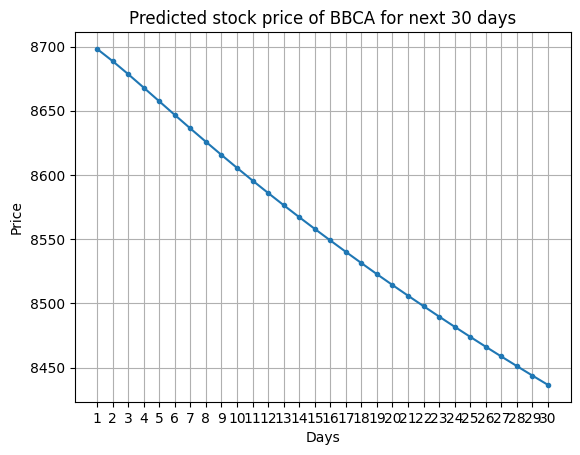

In [26]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of BBCA for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [27]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



3/3 [==============================] - 0s 23ms/step - loss: 0.0018
Validation Loss: 0.0017864927649497986
Validation MSE Loss: 0.0017864927649497986


In [28]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.05704820096128193
Testing RMSE: 0.042266918891668524


Layer = 4

In [29]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 50)               

In [31]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [32]:
checkpoints = ModelCheckpoint(filepath= 'bbca.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
41/41 [==============================] - 15s 138ms/step - loss: 0.1144 - val_loss: 0.0372
Epoch 2/100
41/41 [==============================] - 3s 83ms/step - loss: 0.0595 - val_loss: 0.0109
Epoch 3/100
41/41 [==============================] - 4s 87ms/step - loss: 0.0542 - val_loss: 0.1242
Epoch 4/100
41/41 [==============================] - 4s 92ms/step - loss: 0.0443 - val_loss: 0.0402
Epoch 5/100
41/41 [==============================] - 4s 91ms/step - loss: 0.0408 - val_loss: 0.0416
Epoch 6/100
41/41 [==============================] - 4s 92ms/step - loss: 0.0366 - val_loss: 0.0390
Epoch 7/100
41/41 [==============================] - 3s 82ms/step - loss: 0.0363 - val_loss: 0.0291
Epoch 8/100
41/41 [==============================] - 4s 86ms/step - loss: 0.0323 - val_loss: 0.0241
Epoch 9/100
41/41 [==============================] - 4s 87ms/step - loss: 0.0312 - val_loss: 0.0120
Epoch 10/100
41/41 [==============================] - 3s 81ms/step - loss: 0.0283 - val_loss: 0.02

In [33]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

3/3 [==============================] - 0s 32ms/step


In [34]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [35]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

train_rmse = np.sqrt(mean_squared_error(y_train,train_predict))


0.09114102864439264
0.1042962123964751


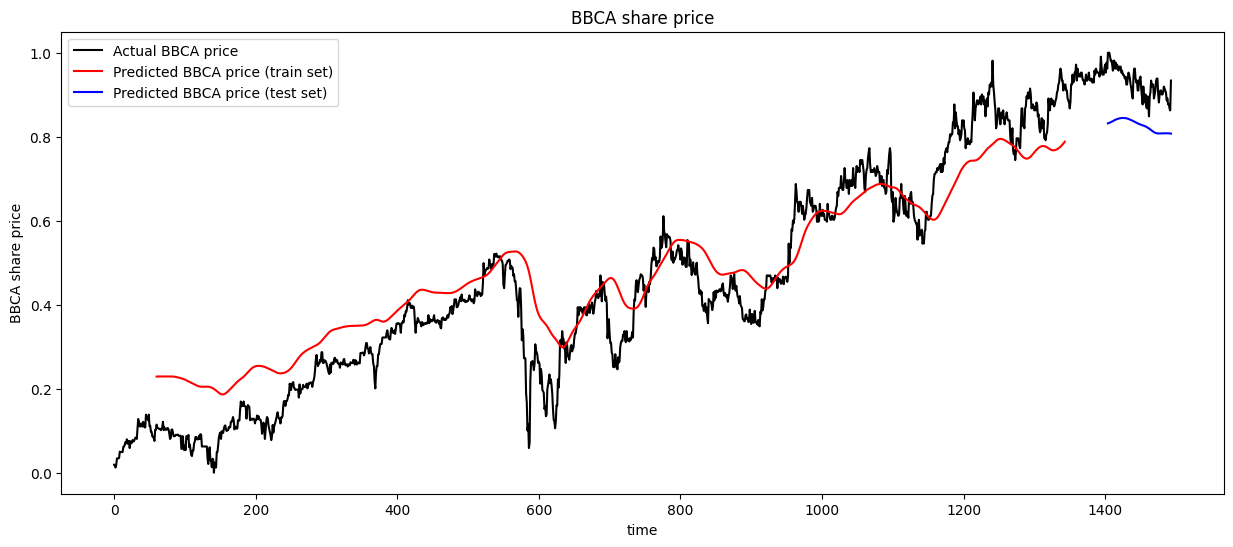

In [36]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual BBCA price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted BBCA price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted BBCA price (test set)")

plt.title(f"BBCA share price")
plt.xlabel("time")
plt.ylabel(f"BBCA share price")
plt.legend()
plt.show()

In [37]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 61ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 8382.919921875
Day 2: Predicted Price = 8380.142578125
Day 3: Predicted Price = 8376.28125
Day 4: Predicted Price = 8371.15625
Day 5: Predicted Price = 8364.677734375
Day 6: Predicted Price = 8356.8173828125
Day 7: Predicted Price = 8347.6474609375
Day 8: Predicted Price = 8337.265625
Day 9: Predicted Price = 8325.638671875
Day 10: Predicted Price = 8313.0234375
Day 11: Predicted Price = 8299.67578125
Day 12: Predicted Price = 8285.83984375
Day 13: Predicted Price = 8271.62109375
Day 14: Predicted Price = 8257.109375
Day 15: Predicted Price = 8242.51953125
Day 16: Predicted Price = 8227.8701171875
Day 17: Predicted Price = 8213.16796875
Day 18: Predicted Price = 8198.5498046875
Day 19: Predicted Price = 8184.0654296875
Day 20: Predicted Price = 8169.86767578125
Day 21: Predicted Price = 8155.94189453125
Day 22: Predicted Price = 8142.30615234375
Day 23: Predicted Price = 8128.

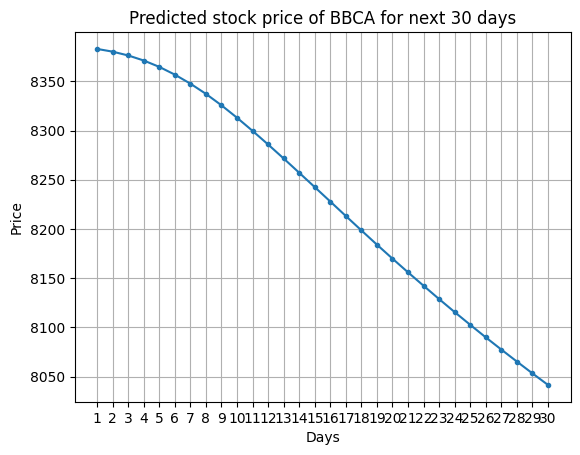

In [38]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of BBCA for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [39]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



3/3 [==============================] - 0s 36ms/step - loss: 0.0109
Validation Loss: 0.010877700522542
Validation MSE Loss: 0.010877700522542


In [40]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.09114102864439264
Testing RMSE: 0.1042962123964751


In [41]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.09114102864439264
Testing RMSE: 0.1042962123964751


Layer = 5

In [42]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_7 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_8 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 50)           

In [44]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [45]:
checkpoints = ModelCheckpoint(filepath= 'bbca.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
41/41 [==============================] - 39s 276ms/step - loss: 0.1338 - val_loss: 0.1695
Epoch 2/100
41/41 [==============================] - 5s 116ms/step - loss: 0.0695 - val_loss: 0.0856
Epoch 3/100
41/41 [==============================] - 5s 127ms/step - loss: 0.0587 - val_loss: 0.0840
Epoch 4/100
41/41 [==============================] - 5s 118ms/step - loss: 0.0505 - val_loss: 0.0241
Epoch 5/100
41/41 [==============================] - 5s 118ms/step - loss: 0.0469 - val_loss: 0.0316
Epoch 6/100
41/41 [==============================] - 5s 112ms/step - loss: 0.0432 - val_loss: 0.0381
Epoch 7/100
41/41 [==============================] - 5s 113ms/step - loss: 0.0390 - val_loss: 0.0453
Epoch 8/100
41/41 [==============================] - 5s 114ms/step - loss: 0.0355 - val_loss: 0.0261
Epoch 9/100
41/41 [==============================] - 5s 123ms/step - loss: 0.0321 - val_loss: 0.0069
Epoch 10/100
41/41 [==============================] - 4s 102ms/step - loss: 0.0303 - val_l

In [46]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

3/3 [==============================] - 0s 38ms/step


In [47]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [48]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

train_rmse = np.sqrt(mean_squared_error(y_train,train_predict))


0.06626064984786688
0.05242382801352717


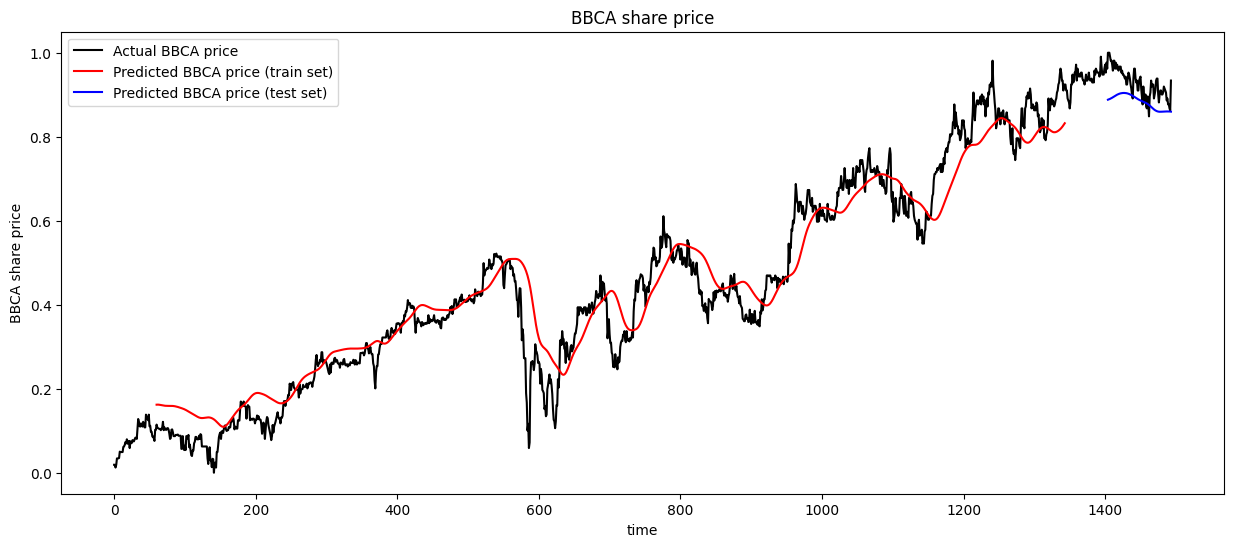

In [49]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual BBCA price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted BBCA price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted BBCA price (test set)")

plt.title(f"BBCA share price")
plt.xlabel("time")
plt.ylabel(f"BBCA share price")
plt.legend()
plt.show()

In [50]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 1s 573ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 8659.1162109375
Day 2: Predicted Price = 8656.970703125
Day 3: Predicted Price = 8654.1162109375
Day 4: Predicted Price = 8650.5205078125
Day 5: Predicted Price = 8646.1826171875
Day 6: Predicted Price = 8641.1025390625
Day 7: Predicted Price = 8635.3466796875
Day 8: Predicted Price = 8628.9658203125
Day 9: Predicted Price = 8621.814453125
Day 10: Predicted Price = 8614.1005859375
Day 11: Predicted Price = 8606.0263671875
Day 12: Predicted Price = 8597.7802734375
Day 13: Predicted Price = 8589.376953125
Day 14: Predicted Price = 8580.8291015625
Day 15: Predicted Price = 8572.3193359375
Day 16: Predicted Price = 8563.791015625
Day 17: Predicted Price = 8555.1884765625
Day 18: Predicted Price = 8546.62890625
Day 19: Predicted Price = 8538.1328125
Day 20: Predicted Price = 8529.8564453125
Day 21: Predicted Price = 8521.7587890625
Day 22: Predicted Price = 8513.8359375
Day 23: Pr

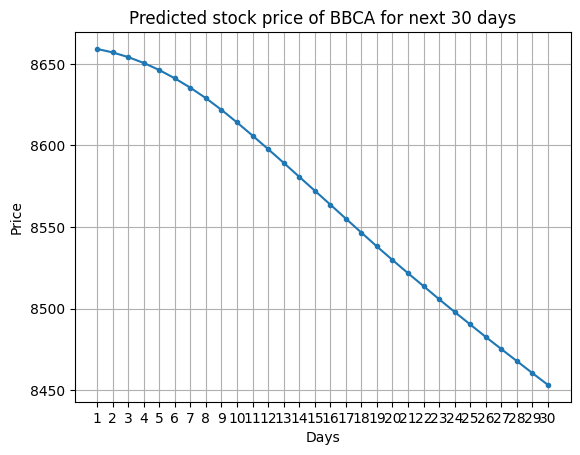

In [51]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of BBCA for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [52]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



3/3 [==============================] - 0s 38ms/step - loss: 0.0027
Validation Loss: 0.002748258179053664
Validation MSE Loss: 0.002748258179053664


In [53]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.06626064984786688
Testing RMSE: 0.05242382801352717


Layer = 6

In [55]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [56]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_12 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_13 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_14 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_14 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_15 (LSTM)              (None, 60, 50)           

In [57]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [58]:
checkpoints = ModelCheckpoint(filepath= 'bbca.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
41/41 [==============================] - 94s 350ms/step - loss: 0.1379 - val_loss: 0.2168
Epoch 2/100
41/41 [==============================] - 6s 140ms/step - loss: 0.0698 - val_loss: 0.0493
Epoch 3/100
41/41 [==============================] - 6s 136ms/step - loss: 0.0560 - val_loss: 0.0512
Epoch 4/100
41/41 [==============================] - 5s 132ms/step - loss: 0.0491 - val_loss: 0.0025
Epoch 5/100
41/41 [==============================] - 6s 138ms/step - loss: 0.0453 - val_loss: 0.0515
Epoch 6/100
41/41 [==============================] - 5s 134ms/step - loss: 0.0436 - val_loss: 0.0241
Epoch 7/100
41/41 [==============================] - 5s 131ms/step - loss: 0.0405 - val_loss: 0.0280
Epoch 8/100
41/41 [==============================] - 5s 130ms/step - loss: 0.0343 - val_loss: 0.0481
Epoch 9/100
41/41 [==============================] - 5s 132ms/step - loss: 0.0325 - val_loss: 0.0695
Epoch 10/100
41/41 [==============================] - 5s 133ms/step - loss: 0.0334 - val_l

In [59]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

3/3 [==============================] - 0s 41ms/step


In [60]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [61]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

train_rmse = np.sqrt(mean_squared_error(y_train,train_predict))


0.06805231726711103
0.04778610086311384


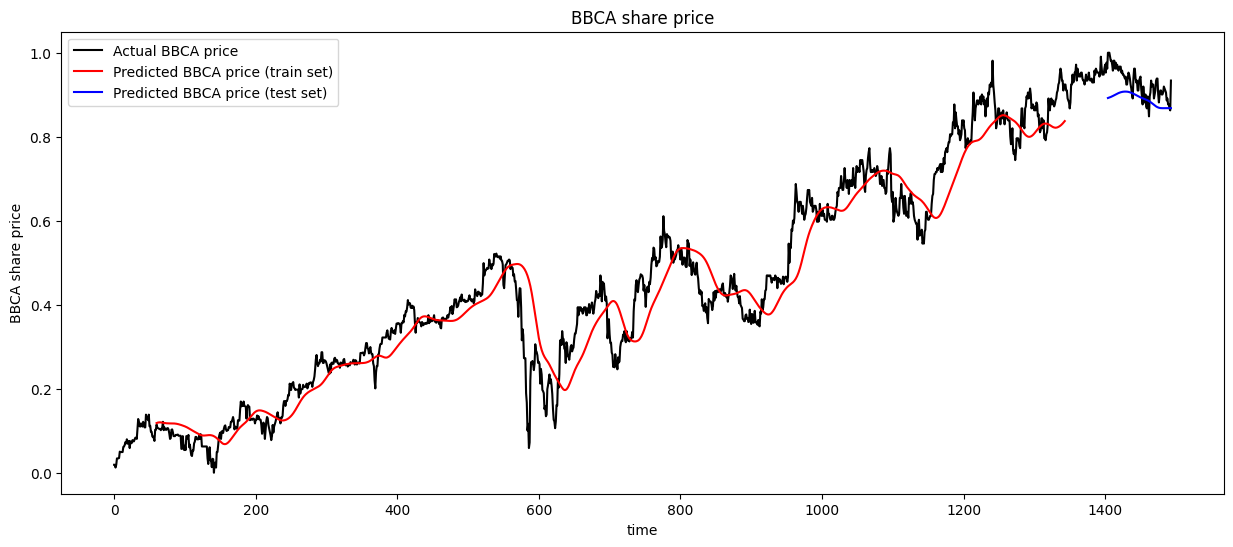

In [62]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual BBCA price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted BBCA price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted BBCA price (test set)")

plt.title(f"BBCA share price")
plt.xlabel("time")
plt.ylabel(f"BBCA share price")
plt.legend()
plt.show()

In [63]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 73ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 8703.4931640625
Day 2: Predicted Price = 8702.18359375
Day 3: Predicted Price = 8700.4462890625
Day 4: Predicted Price = 8698.26171875
Day 5: Predicted Price = 8695.630859375
Day 6: Predicted Price = 8692.494140625
Day 7: Predicted Price = 8688.8984375
Day 8: Predicted Price = 8684.8330078125
Day 9: Predicted Price = 8679.8662109375
Day 10: Predicted Price = 8674.2880859375
Day 11: Predicted Price = 8668.384765625
Day 12: Predicted Price = 8662.431640625
Day 13: Predicted Price = 8656.3662109375
Day 14: Predicted Price = 8650.12890625
Day 15: Predicted Price = 8644.02734375
Day 16: Predicted Price = 8637.8974609375
Day 17: Predicted Price = 8631.5771484375
Day 18: Predicted Price = 8625.2802734375
Day 19: Predicted Price = 8619.0322265625
Day 20: Predicted Price = 8613.140625
Day 21: Predicted Price = 8607.515625
Day 22: Predicted Price = 8602.150390625
Day 23: Predicted Price

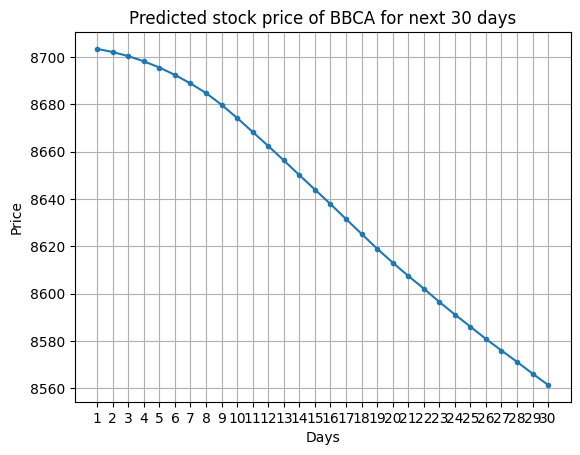

In [64]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of BBCA for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [65]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



3/3 [==============================] - 0s 45ms/step - loss: 0.0023
Validation Loss: 0.0022835119161754847
Validation MSE Loss: 0.0022835119161754847


In [66]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.06805231726711103
Testing RMSE: 0.04778610086311384


: 